In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import json
import polars as pl
import os
# from lightgbm import LGBMRegressor
# import lightgbm as lgb

In [2]:
# overfitting/underfitting, 
# data drift, 
# data imbalance

In [3]:
# make predictions 
# The predictions are made too early in the day (11am? or ealier) to get current-day data for certain things like the gas and electricity prices.

In [4]:
df_client = pd.read_csv(r'C:\Users\gabri\VSCode Projects\Data Science Skills\Enefit\client.csv')
df_gas = pd.read_csv(r'C:\Users\gabri\VSCode Projects\Data Science Skills\Enefit\gas_prices.csv')
df_elec = pd.read_csv(r'C:\Users\gabri\VSCode Projects\Data Science Skills\Enefit\electricity_prices.csv')
df_train = pd.read_csv(r'C:\Users\gabri\VSCode Projects\Data Science Skills\Enefit\train.csv')
df_historical = pd.read_csv(r'C:\Users\gabri\VSCode Projects\Data Science Skills\Enefit\historical_weather.csv')
df_weather_forecast = pd.read_csv(r'C:\Users\gabri\VSCode Projects\Data Science Skills\Enefit\forecast_weather.csv')

df_test = pd.read_csv(r'C:\Users\gabri\VSCode Projects\Data Science Skills\Enefit\example_test_files\test.csv')
df_revealed = pd.read_csv(r'C:\Users\gabri\VSCode Projects\Data Science Skills\Enefit\example_test_files\revealed_targets.csv')

In [5]:
df_client['is_business'] = df_client['is_business'].astype("category")
df_client['product_type'] = df_client['product_type'].astype("category")
df_client['county'] = df_client['county'].astype("category")

In [6]:
path = r'C:\Users\gabri\VSCode Projects\Data Science Skills\Enefit\county_id_to_name_map.json'
with open(path, 'r') as f:
    county_names = json.load(f)
county_names = {int(key): value for key, value in county_names.items()}
df_client['county_name'] = df_client['county'].map(county_names)

C:\Users\gabri\AppData\Local\Temp\ipykernel_18908\320944879.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  business_type_grouping = df_client.groupby('is_business').mean('installed_capacity')


Text(0.5, 0.98, 'Average values by business')

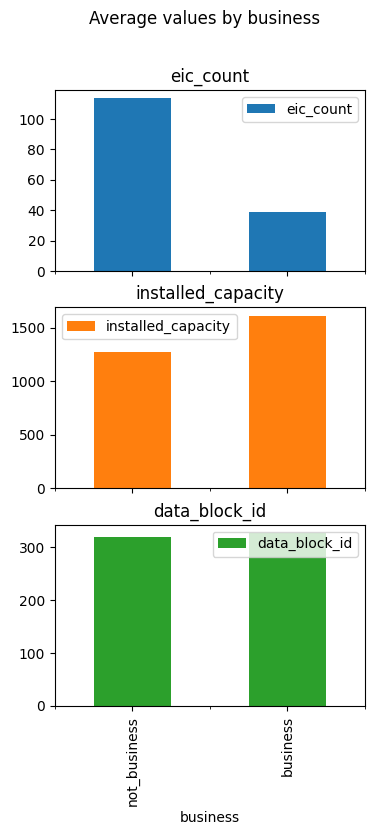

In [7]:
business_type_grouping = df_client.groupby('is_business').mean('installed_capacity')
business_type_grouping['business'] = ['not_business', 'business']
ax = business_type_grouping.plot.bar(x='business', subplots=True, figsize=(4,8))
ax[0].figure.suptitle("Average values by business")

In [8]:
product_type_business_type_grouping = df_client.groupby(['product_type', 'is_business']).size().unstack(fill_value=0)
product_dic = {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}
fig = px.bar(x=product_type_business_type_grouping.index, y=[product_type_business_type_grouping[0], product_type_business_type_grouping[1]])
fig.update_xaxes(tickvals=list(product_dic.keys()), ticktext=list(product_dic.values()), title_text='Product Type')
fig.update_layout(width=600, height=300)

C:\Users\gabri\AppData\Local\Temp\ipykernel_18908\3080157589.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_type_business_type_grouping = df_client.groupby(['product_type', 'is_business']).size().unstack(fill_value=0)


In [9]:
county_customer_count_df = df_client.groupby(['county_name', 'is_business'], observed=True).count()
county_customer_count_df = county_customer_count_df.reset_index()

fig = px.bar(data_frame=county_customer_count_df, x='county_name', y='eic_count', color='is_business')
fig.update_layout(width=600, height=300, title = 'count by segment (business, product, area)')
fig.update_xaxes(title_text='County name')
fig.update_yaxes(title_text='Customer Count by Business')

c:\Users\gabri\miniconda3\Lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [10]:
count_by_segment = df_train.groupby('prediction_unit_id').count()
fig = px.bar(x=count_by_segment.index,y=count_by_segment['county'])
timestamps_per_segment = len(df_train[df_train['prediction_unit_id'] == 0])
print('Number of hourly records: ', timestamps_per_segment, 'Some segments have fewer as they were launched later')
segment_count = len(count_by_segment)
print(f'Number of unique segments: {segment_count}')
fig.update_layout(width=600, height=300, title = 'Number of records per Segment')
fig.update_xaxes(title_text='Unique Segment ID')
fig.update_yaxes(title_text='Timestamps per segment')

Number of hourly records:  30624 Some segments have fewer as they were launched later
Number of unique segments: 69


In [11]:
df_train['date'] = pd.to_datetime(df_train['datetime']).dt.date
df_train.groupby(['county', 'is_business', 'product_type', 'date', 'is_consumption']).sum()

target  \
county is_business product_type date       is_consumption             
0      0           1            2021-09-01 0               2797.045   
                                           1               1919.274   
                                2021-09-02 0               2496.087   
                                           1               2095.129   
                                2021-09-03 0               2299.575   
...                                                             ...   
15     1           3            2023-05-29 1               7462.889   
                                2023-05-30 0               5899.625   
                                           1               7787.871   
                                2023-05-31 0               8330.142   
                                           1               6437.183   

                                                                                                    datetime  \
county is_business product_type date       is_consumption                                                      
0      0           1            2021-09-01 0               2021-09-01 00:00:002021-09-01 01:00:002021-09-...   
                                           1               2021-09-01 00:00:002021-09-01 01:00:002021-09-...   
                                2021-09-02 0               2021-09-02 00:00:002021-09-02 01:00:002021-09-...   
                                           1               2021-09-02 00:00:002021-09-02 01:00:002021-09-...   
                                2021-09-03 0               2021-09-03 00:00:002021-09-03 01:00:002021-09-...   
...                                                                                                      ...   
15     1           3            2023-05-29 1               2023-05-29 00:00:002023-05-29 01:00:002023-05-...   
                                2023-05-30 0               2023-05-30 00:00:002023-05-30 01:00:002023-05-...   
                                           1               2023-05-30 00:00:002023-05-30 01:00:002023-05-...   
                                2023-05-31 0               2023-05-31 00:00:002023-05-31 01:00:002023-05-...   
                                           1               2023-05-31 00:00:002023-05-31 01:00:002023-05-...   

                                                           data_block_id  \
county is_business product_type date       is_consumption                  
0      0           1            2021-09-01 0                           0   
                                           1                           0   
                                2021-09-02 0                          24   
                                           1                          24   
                                2021-09-03 0                          48   
...                                                                  ...   
15     1           3            2023-05-29 1                       15240   
                                2023-05-30 0                       15264   
                                           1                       15264   
                                2023-05-31 0                       15288   
                                           1                       15288   

                                                             row_id  \
county is_business product_type date       is_consumption             
0      0           1            2021-09-01 0                  33672   
                                           1                  33696   
                                2021-09-02 0                 103944   
                                           1                 103968   
                                2021-09-03 0                 174216   
...                                                             ...   
15     1           3            2023-05-29 1               48254784   
                                2023-05-30 0        

In [12]:
df_client_filtered = df_client.copy()  # Make a copy to avoid modifying the original DataFrame
df_client_filtered['product_type'] = df_client_filtered['product_type'].astype('str')
df_client_filtered['product_business_type'] = 'p' + df_client_filtered['product_type'] + '_b' + df_client_filtered['is_business'].astype('str') + '_c' + df_client_filtered['county'].astype('str')
fig = px.scatter(data_frame=df_client_filtered, x='date', y='eic_count', color='product_business_type', title='Scatter Plot of EIC Count Over Time')
fig.update_layout(width=900, height=400, title = 'Number of customers by regional, business and product segment (69 segments in total)')
fig.update_yaxes(title_text='Individual and business count')

In [13]:
df_train_copy = df_train.copy()
df_train_copy['is_consumption'] = df_train_copy['is_consumption'].replace(1, -1)
df_train_copy['is_consumption'] = df_train_copy['is_consumption'].replace(0, 1)
df_train_copy['energy_exchange'] = df_train_copy['target'] * df_train['is_consumption']
net_energy_usage = df_train_copy.groupby(['prediction_unit_id', 'datetime']).sum('energy_exchange')
net_energy_usage = net_energy_usage.reset_index()
net_energy_usage['prediction_unit_id_str'] = net_energy_usage['prediction_unit_id'].astype('str')

In [14]:
# enter the id for the segment you want to look at
segments = [1]
fig = go.Figure()
fig.add_trace(go.Scatter(x=net_energy_usage[net_energy_usage['prediction_unit_id'].isin(segments)]['datetime'],
    y=net_energy_usage[net_energy_usage['prediction_unit_id'].isin(segments)]['energy_exchange'], name='Net Energy Usage'))
fig.add_trace(go.Scatter(x=df_gas['origin_date'], y=df_gas['lowest_price_per_mwh'], name='gas_price'))
fig.add_trace(go.Scatter(x=df_elec['origin_date'], y=df_elec['euros_per_mwh'], name='electric price'))
fig.show()

In [15]:
px.scatter(data_frame=df_gas, x='origin_date', y =['lowest_price_per_mwh', 'highest_price_per_mwh'])

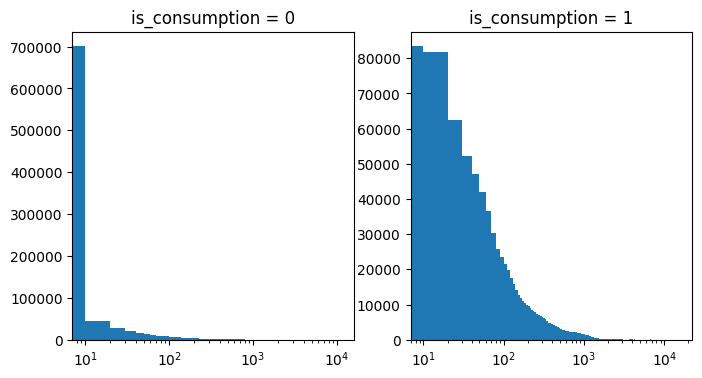

In [16]:
target_0 = df_train[df_train['is_consumption'] == 0]['target']
target_1 = df_train[df_train['is_consumption'] == 1]['target']

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_title('is_consumption = 0')
target_0 = df_train[df_train['is_consumption'] == 0]['target']
width = 10
bin_edges = np.arange(min(target_0), max(target_0) + width, width)
axs[0].hist(target_0, bins=bin_edges)
axs[0].set_xscale('log')

axs[1].set_title('is_consumption = 1')
target_1 = df_train[df_train['is_consumption'] == 1]['target']
width = 10
bin_edges = np.arange(min(target_1), max(target_1) + width, width)
axs[1].hist(target_1, bins=bin_edges)
axs[1].set_xscale('log')

plt.show()

In [17]:
print(f"Training data_block_id min {df_train['data_block_id'].min()} and max {df_train['data_block_id'].max()}. datetime {df_train['datetime'].min()} - {df_train['datetime'].max()}")
print(f"Test data_block_id min {df_test['data_block_id'].min()} and max {df_test['data_block_id'].max()}. prediction_datetime range {df_test['prediction_datetime'].min()} - {df_test['prediction_datetime'].max()}")
print(f"Revealed_targets data_block_id min {df_revealed['data_block_id'].min()} and max {df_revealed['data_block_id'].max()}. datetime range {df_revealed['datetime'].min()} - {df_revealed['datetime'].max()}")
print(f"Unique data_block_id present in TEST {df_test['data_block_id'].unique()}")
print(f"Unique data_block_id present in REVEALED {df_revealed['data_block_id'].unique()}")

Training data_block_id min 0 and max 637. datetime 2021-09-01 00:00:00 - 2023-05-31 23:00:00
Test data_block_id min 634 and max 637. prediction_datetime range 2023-05-28 00:00:00 - 2023-05-31 23:00:00
Revealed_targets data_block_id min 634 and max 637. datetime range 2023-05-26 00:00:00 - 2023-05-29 23:00:00
Unique data_block_id present in TEST [634 635 636 637]
Unique data_block_id present in REVEALED [634 635 636 637]


In [18]:
# objective:
# you have private prosumers and business prosumers throughout the country that consume electricity from the grid and add generate and sell electricity to the grid with their PV
# when it is sunny, PV works, when no sun, then little or no PV outout
# when the price of electricity is high, then it makes sense to sell PVE, when it is low, it makes more sense to consume it
# businesses more likely to consume PVE when the grid price is low, maybe sell when the price is high.
# prosumers are small as a percentage of electricity consumers, but have a high impact, and the numbers are increasing
# tackle energy imbalance, which occurs when true energy consumption is not what was predicted leading to high costs and loss of grid reliability
# Enefit builds models to predict the energy behaviour or prosumers (when the sell and when they consume)
# part of the reason for this behaviour is the numerous number of factors affecting their energy behavior
# very simply, predict electricity produced and consumed by energy custoemrs with PV
# energy prices affect prosumers behavior, weather affects it, more likely to heat in cold weather
# objective is to build a model that at 11am each day can forecast the energy consumption and production for each segment for the following day?
# intially, build a simple model without time-dimension that predicts target_0 and target_1 for each segment each hour

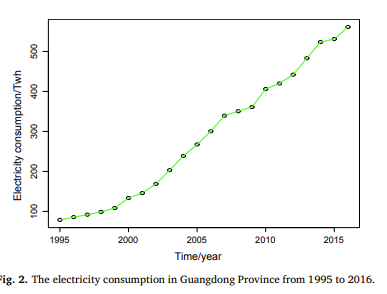

Block data ID Alignment

In [19]:
# https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/discussion/453008

In [20]:
# block_data_id = 10, all values in relation to time of training/prediction at 11:00
# Training / real-time prediction on 2021-11-09 - 11:00:00 (df_train)
# -24hour DAILY client information, no issues (df_client) - SIMPLY JOIN THE CURRENT EIC_COUNT WITHOUT TIME DIMENSION
# -48hours to -24hours of HOURLY historical weather - MIGHT CONSIDER USING 3 DAYS OF HISTORICAL DATA, MORE COULD BE ADDED
# -24hours to +24hours of HOURLY weather forecast data - MIGHT CONSIDER USING BOTH -24 HOURS AND +24 HOURS
# -24hour DAILY gas price made at -48hours - GAS PRICE QUITE STABLE BETWEEN DAYS SO FORECAST MADE BE GOOD ENOUGH
# -48hour to -24hour HOURLY forecast of electric - ELECTRICITY VARIES SIGNIFICANTLY DEPENDING ON TIME OF DAY AS YOU BECAUSE OF POWER STATION AVAILABILITY

In [21]:
def load_data(base_dir: str):

    # Dictionary to hold the loaded data
    data = {}

    # Paths to the different types of files
    files_to_load = {
        "client": "client.csv",
        "electricity_prices": "electricity_prices.csv",
        "forecast_weather": "forecast_weather.csv",
        "gas_prices": "gas_prices.csv",
        "historical_weather": "historical_weather.csv",
        "train": "train.csv"
    }

    # Load CSV files
    for key, filename in files_to_load.items():
        file_path = os.path.join(base_dir, filename)
        temp_df = pd.read_csv(file_path)

        # Convert columns that contain 'date' in their name to datetime objects
        for col in temp_df.columns:
            if 'date' in col.lower():
                temp_df[col] = pd.to_datetime(temp_df[col])

        data[key] = temp_df

    # Return the dictionary of loaded data
    return data

def show_unique_days_hours(dataframes, data_block_id):
    print(f"Unique datetime values for data_block_id {data_block_id}")

    for key, df in dataframes.items():
        print(f"-----{key}-----")
        # Filter the dataframe for the given data_block_id
        filtered_df = df.loc[df.data_block_id == data_block_id]

        # Iterate through each column to check for datetime columns
        for column in filtered_df.columns:
            if pd.api.types.is_datetime64_any_dtype(filtered_df[column]):
                # Extract unique days and hours
                unique_days = sorted(filtered_df[column].dt.date.unique())
                unique_hours = sorted(filtered_df[column].dt.hour.unique())
                count_unique_hours = len(unique_hours)

                # Find the range of dates
                date_range = filtered_df[column].agg(['min', 'max'])
                date_range = "static" if date_range["min"] == date_range["max"] else f"{date_range['min']} to {date_range['max']}"

                # Print the unique values and the range
                print(f"Unique days in column '{column}': {unique_days}")
                print(f"Number of unique hours in column '{column}': {unique_hours if count_unique_hours <= 1 else count_unique_hours}")
                print(f"Date range in column '{column}': {date_range}")
                print("")

# init data dict
trnval_data = load_data(r'C:\Users\gabri\VSCode Projects\Data Science Skills\Enefit')

# show unique datetime objects for fixed data_block_id
data_block_id = 10
show_unique_days_hours(trnval_data, data_block_id)

Unique datetime values for data_block_id 10
-----client-----
Unique days in column 'date': [datetime.date(2021, 9, 9)]
Number of unique hours in column 'date': [0]
Date range in column 'date': static

-----electricity_prices-----
Unique days in column 'forecast_date': [datetime.date(2021, 9, 10)]
Number of unique hours in column 'forecast_date': 24
Date range in column 'forecast_date': 2021-09-10 00:00:00 to 2021-09-10 23:00:00

Unique days in column 'origin_date': [datetime.date(2021, 9, 9)]
Number of unique hours in column 'origin_date': 24
Date range in column 'origin_date': 2021-09-09 00:00:00 to 2021-09-09 23:00:00

-----forecast_weather-----
Unique days in column 'origin_datetime': [datetime.date(2021, 9, 10)]
Number of unique hours in column 'origin_datetime': [2]
Date range in column 'origin_datetime': static

Unique days in column 'forecast_datetime': [datetime.date(2021, 9, 10), datetime.date(2021, 9, 11), datetime.date(2021, 9, 12)]
Number of unique hours in column 'forecast